# Project: Train a Quadcopter How to Fly

In this project I will design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm. Concretely, I'll usea a Deep Deterministic Policy Gradient algorithm, based on an actor-critic scheme.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: The task (environment) is defined in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: The TakeOff and Landing agent are here.
- `physics_sim.py`: This file contains the simulator for the quadcopter. 


## Controlling the Quadcopter

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors. These four speeds are returned by the `act` method as a list of four floating-point numbers.  

## The Task 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The tasks in the task.py file are TakeOff and Landing. In both of them we want the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent call this method every time the episode ends.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

## Define the Task, Design the Agent, and Train Your Agent!

### TakeOff Agent

In [2]:
## This agent will learn how to take off
import sys 
import pandas as pd
import numpy as np
from agents.agent import DDPG
from task import TakeOff
import csv

# Starting position
runtime = 5.0
init_pose = np.array([0., 0., np.random.normal(0.5,1), 0., 0., 0.])
num_episodes = 250
target_pos = np.array([0., 0., 10.])
task = TakeOff(init_pose=init_pose, target_pos=target_pos, runtime=runtime)
agent = DDPG(task)

# Setup
takeoff_output = 'takeoff_data.txt'
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 
          'rotor_speed4', 'episode', 'total_reward']

results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(takeoff_output, 'w') as takeoffcsvfile:
    writer = csv.writer(takeoffcsvfile)
    writer.writerow(labels)
    for i_episode in range(1, num_episodes+1):
        state = agent.reset_episode() # start a new episode
        while True:
            action = agent.act(state) 
            next_state, reward, done = task.step(action)
            agent.step(action, reward,next_state, done)
            state = next_state
           
            if done:
                to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action) + [i_episode] + [agent.total_reward]
                for ii in range(len(labels)):
                    results[labels[ii]].append(to_write[ii])
                writer.writerow(to_write)
                print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f})".format(
                    i_episode, agent.total_reward, agent.biggest_total_reward), end="")  # [debug]
                break
        sys.stdout.flush()

Using TensorFlow backend.


Episode =  250, score = 252.000 (best = 252.000)

## Plot the Rewards

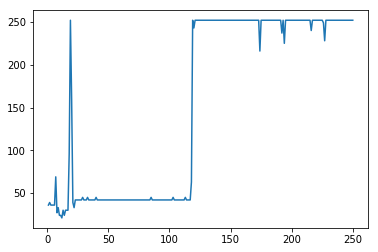

In [4]:
# Reward through simulations
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['episode'], results['total_reward'])
plt.legend()
_ = plt.ylim()

In [6]:
# Mean of 20 last records
np.mean(results['total_reward'][-20:])

252.0

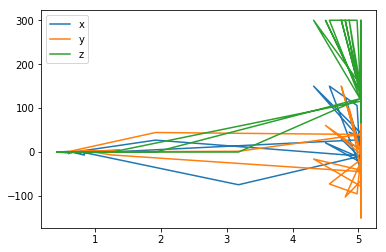

In [7]:
# Position during the simulation
plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

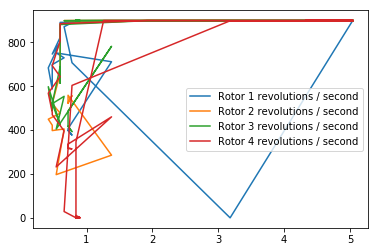

In [8]:
# Agent's actions
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

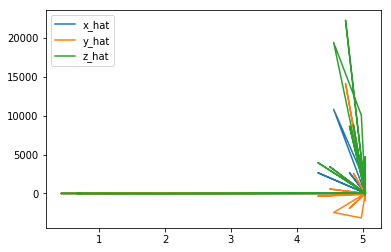

In [9]:
#velocity
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

### Landing Agent

In [11]:
## This agent will learn how to land
import sys 
import pandas as pd
import numpy as np
from agents.agent import DDPG
from task import Landing
import csv

# Starting position
runtime = 5.0
init_pose = np.array([0., 0., 20., 0., 0., 0.])
num_episodes = 250
target_pos = np.array([0., 0., 0.])
task = Landing(init_pose=init_pose, target_pos=target_pos, runtime=runtime)
agent = DDPG(task)

# Setup
landing_output = 'landing_data.txt'
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 
          'rotor_speed4', 'episode', 'total_reward']

results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(landing_output, 'w') as landingcsvfile:
    writer = csv.writer(landingcsvfile)
    writer.writerow(labels)
    for i_episode in range(1, num_episodes+1):
        state = agent.reset_episode() # start a new episode
        while True:
            action = agent.act(state) 
            next_state, reward, done = task.step(action)
            agent.step(action, reward,next_state, done)
            state = next_state
           
            if done:
                to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action) + [i_episode] + [agent.total_reward]
                for ii in range(len(labels)):
                    results[labels[ii]].append(to_write[ii])
                writer.writerow(to_write)
                print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f})".format(
                    i_episode, agent.total_reward, agent.biggest_total_reward), end="")  # [debug]
                break
        sys.stdout.flush()

Episode =  250, score = 108.000 (best = 252.000)

## Plot the Rewards

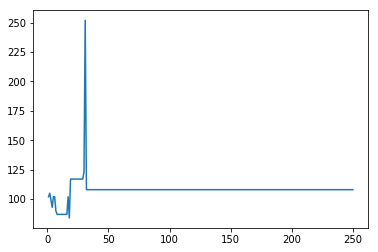

In [12]:
# Reward during simulations
plt.plot(results['episode'], results['total_reward'])
plt.legend()
_ = plt.ylim()

In [13]:
#mean of last records
np.mean(results['total_reward'][-10:])

108.0

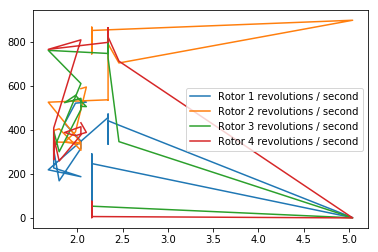

In [14]:
#agent's actions 
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

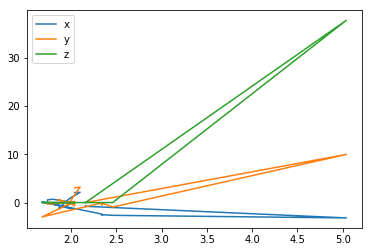

In [15]:
#position during simulation
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

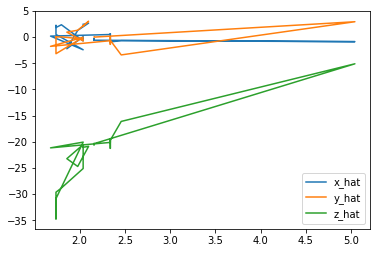

In [16]:
#velocity
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

## Reflections

### Results

The agent performed two tasks: take off and landing.

In the TakeOff task, the reward was designed to multiply the absolute difference between the current position and the target by -0.3 and then substract 1. The reward function then would return 1 if the previous operations were positive and -1 otherwise.

In the Landing task, the reward was designed in the same way as in the TakeOff task, but with the difference that the absolute difference was inversed.

### Algorithm, Hyperparameters and Architecture

- I tried the suggested DDPG algorithm, as an agent with actor-critic and using neural networks for training them.

- I tried different combinations for gamma and tau, but finally kept with the starting ones: Gamma = 0.99, Tau = 0.01

- I tried several combinations, but finally kept the following:
        1) For the actor: 3 Dense layers of (32,64,32) sizes and activation Relu. And the final layer with sigmoid as activation.
        2) For the critic: 2 Dense layers of (32,64) sizes and relu activation, for both actions and states pathways.

### Learning Performance

- Looking at the plots, it seems like both aren't hard tasks to learn, as the maximum score is achieved relatively soo. However, the score drops significantly as the episodes progresses. In the case of the Takeoff task, it recovered quickly to the best score but that is not the case with Landing.

- In both cases there is definately an aha moment, befor the episode 50, where the scores improve dramatically before dropping again.

- Regardign the final performance:
        1) For TakeOff: The final performance is the same as the maximum score achieved, so we can infer that the agent learned pretty well this task.
        2) For Landing: The final performance score is 108.0, which is significantly worse than the maximum.